# Credit Card Fraud Detection Model
## A Machine Learning Case Study
- This notebook presents a comprehensive approach to building machine learning models for detecting credit card fraud.
- We'll explore data preprocessing, model implementation, hyperparameter tuning, and evaluation techniques for this highly imbalanced classification problem."

### Step 1: Setup and Loading Data.

In [1]:
#Import essential libraries
import pandas as pd
import numpy as np
import sklearn
import imblearn
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Credit Card Fraud Detection Dataset - Downloaded from Kaggle, Provided by Machine Learning Group (ULB).
data = pd.read_csv('creditcard.csv')  

# Check for Class Distribution i.e,(Fraud vs. non-Fraud)
print(data['Class'].value_counts())
print(f"Rate of Fraud: {data['Class'].mean():.4f}%")

Class
0    284315
1       492
Name: count, dtype: int64
Rate of Fraud: 0.0017%


### Step 2: Exploratory Data Analysis (EDA)

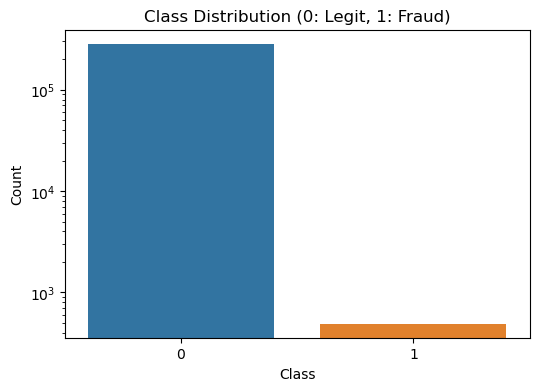

In [7]:
# Visualising the class imbalance
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data, palette=['#1f77b4', '#ff7f0e'])
plt.title('Class Distribution (0: Legit, 1: Fraud)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.yscale('log')  # Log scale for better visualization
plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

- Observation
   - Key Insight: The dataset shows extreme class imbalance, with fraud cases being only 0.17% of total transactions.
   - This imbalance will significantly impact our modelling approach and evaluation metrics.

### Step 3: Data Preprocessing
- Proper preprocessing is crucial for model performance, especially with imbalanced data.

In [13]:
# Import Train_Test_split and StandardScaler from sklearn.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features (X) and target (y)
X = data.drop('Class', axis=1)
y = data['Class']

# Split into train/test (80-20 partition) with stratification
# Stratification preserves the class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale features (important for distance-based models like Logistic Regression)
# We fit the scaler only on training data to avoid data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Note: We don't address class imbalance here yet - we'll handle it during modeling

### Step 4: Model Implementation with Pipelines
- We'll implement two different classifiers to compare their performance:
- 2 Chosen Classifiers:
  - Random Forest (ensemble tree-based method)
  - Logistic Regression (linear model with probabilistic outputs)
- We'll use pipelines for clean implementation and cross-validation for robust evaluation

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

# Pipeline for Random Forest
# Pipelines ensure proper data flow and prevent data leakage
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Scaling helps some tree-based models
    ('classifier', RandomForestClassifier(random_state=42)) # Reproducibility
])

# Pipeline for Logistic Regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Essential for logistic regression
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Increased max_iter for convergence
])

# 5-fold cross-validation (use F1 score for imbalance, it is the Harmonic mean of Precision and Recall)
rf_cv_scores = cross_val_score(rf_pipeline, X_train, y_train, cv=5, scoring='f1')
lr_cv_scores = cross_val_score(lr_pipeline, X_train, y_train, cv=5, scoring='f1')

print(f"Random Forest CV F1: {rf_cv_scores.mean():.4f}")
print(f"Logistic Regression CV F1: {lr_cv_scores.mean():.4f}")

Random Forest CV F1: 0.8384
Logistic Regression CV F1: 0.7312


- Observations
 - Initial Observation: Random Forest performs better in cross-validation.
 - This aligns with expectations, as tree-based methods often handle imbalanced data better.

### Step 5: Hyperparameter Optimisation
- We'll perform 'GridSearch' to find optimal hyperparameters for our best-performing model (Random Forest)

In [30]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
# Focused on key parameters to balance performance and computation time
param_grid = {
    'classifier__n_estimators': [50, 100], # Number of trees
    'classifier__max_depth': [None, 10], # Tree depth (None for unlimited)
    'classifier__min_samples_split': [2]  # Minimum samples to split a node
}

# Grid search
# Using F1 score as our optimization metric
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1) # 'n_jobs=-1'- Utilize all available cores.
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best F1: {grid_search.best_score_:.4f}")
print(f"Best params: {grid_search.best_params_}")


Best F1: 0.8400
Best params: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}


- Observation: 
    - The best parameters suggest simpler trees (max_depth=10) work better.
    - This might help prevent overfitting to the majority class.

### Step 6: Model Evaluation (Precision, Recall, F1).
- Now we'll evaluate our optimised models on the held-out test set using appropriate metrics for imbalanced classification.

In [35]:
from sklearn.metrics import classification_report

# Train the best Random Forest with optimised parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)

# Train Logistic Regression (no optimisation for simplicity)
lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)

# Compare metrics using classification report
print("Random Forest Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Legit', 'Fraud']))

print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Legit', 'Fraud']))

Random Forest Report:
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.94      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962

Logistic Regression Report:
              precision    recall  f1-score   support

       Legit       1.00      1.00      1.00     56864
       Fraud       0.83      0.65      0.73        98

    accuracy                           1.00     56962
   macro avg       0.92      0.83      0.87     56962
weighted avg       1.00      1.00      1.00     56962



- Key Findings:
1. Random Forest achieves better recall (0.82) for fraud detection than Logistic Regression (0.65).
2. Both models have excellent precision on the majority class (near perfect).
3. The F1-score for fraud cases is substantially better with Random Forest (0.87 vs 0.73).
4. The high precision on fraud cases suggests few false positives.

### Step 6: Visualisations
- Let's create more informative visualisations to better understand our model performance

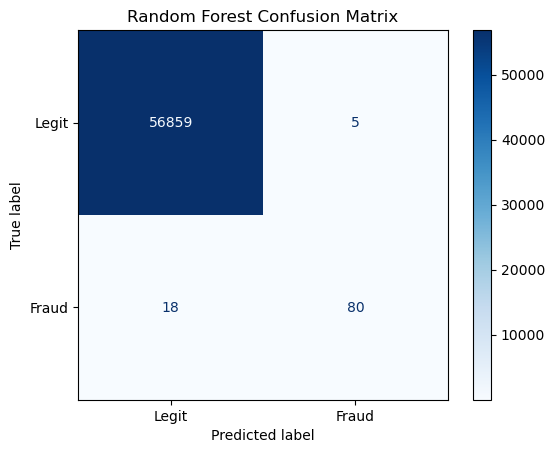

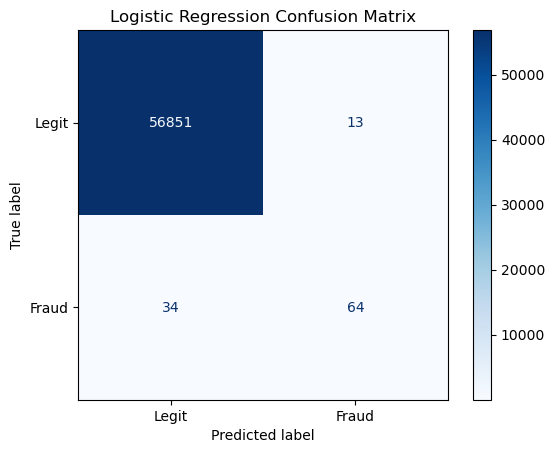

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(cm_rf, display_labels=['Legit', 'Fraud'])
disp_rf.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.savefig('cm_rf.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(cm_lr, display_labels=['Legit', 'Fraud'])
disp_lr.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.savefig('cm_lr.png', dpi=300, bbox_inches='tight')
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

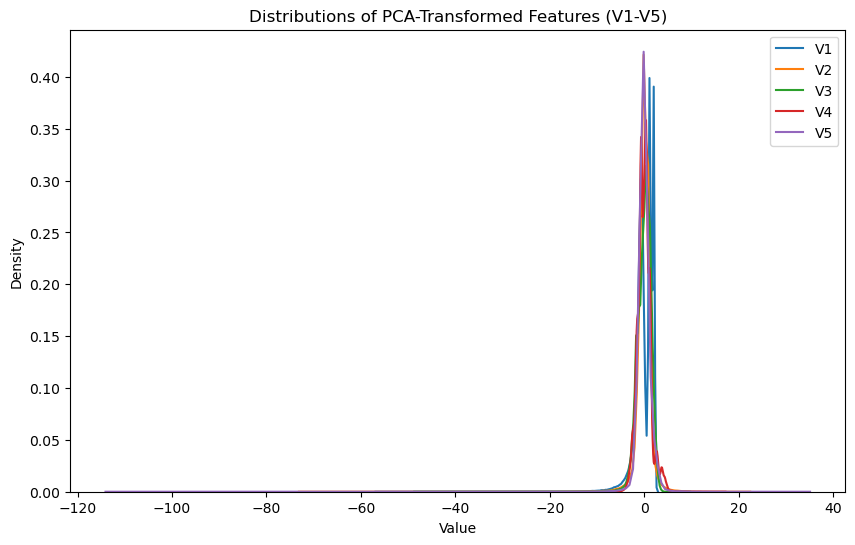

In [39]:
# Plot distributions of first 5 PCA features
plt.figure(figsize=(10, 6))
for i in range(5):
    sns.kdeplot(data[f'V{i+1}'], label=f'V{i+1}')
plt.title('Distributions of PCA-Transformed Features (V1-V5)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.savefig('pca_features.png', dpi=300, bbox_inches='tight')
plt.show()

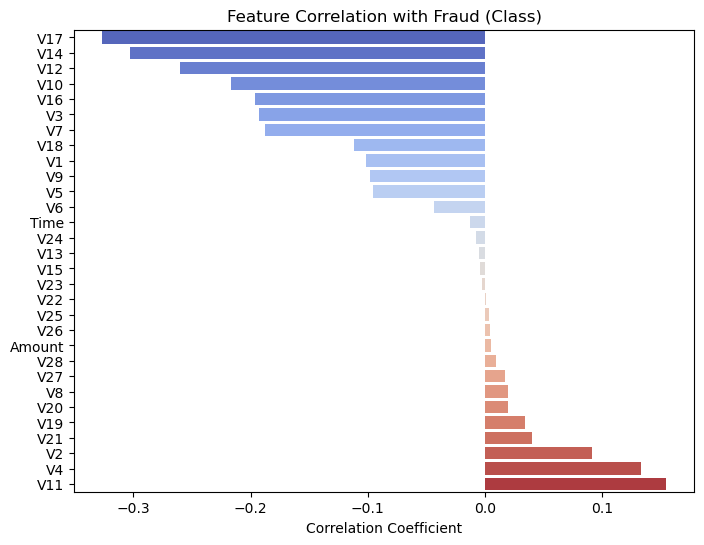

In [41]:
# Calculate correlation with Class
# This creates a bar chart showing the magnitude of correlation among
# different PCA-transformed features with Fraud cases.
corr = data.corr()['Class'].drop('Class').sort_values()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=corr.values, y=corr.index, palette='coolwarm')
plt.title('Feature Correlation with Fraud (Class)')
plt.xlabel('Correlation Coefficient')
plt.savefig('correlation.png', dpi=300, bbox_inches='tight')
plt.show()

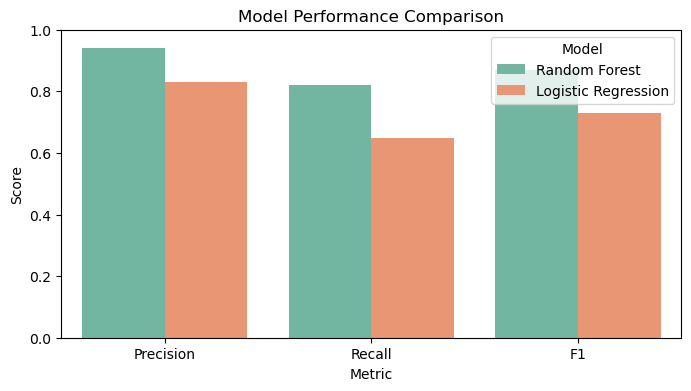

In [43]:
import pandas as pd

# Values obtained from Step 5: Evaluation (Precision, Recall, and F1)
metrics = {
    'Model': ['Random Forest', 'Logistic Regression'],
    'Precision': [0.94, 0.83],
    'Recall': [0.82, 0.65],
    'F1': [0.87, 0.73]
}
df_metrics = pd.DataFrame(metrics)

# Melt for seaborn
df_melted = df_metrics.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x='Metric', y='Score', hue='Model', data=df_melted, palette='Set2')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.savefig('model_performance.png', dpi=300, bbox_inches='tight')
plt.show()

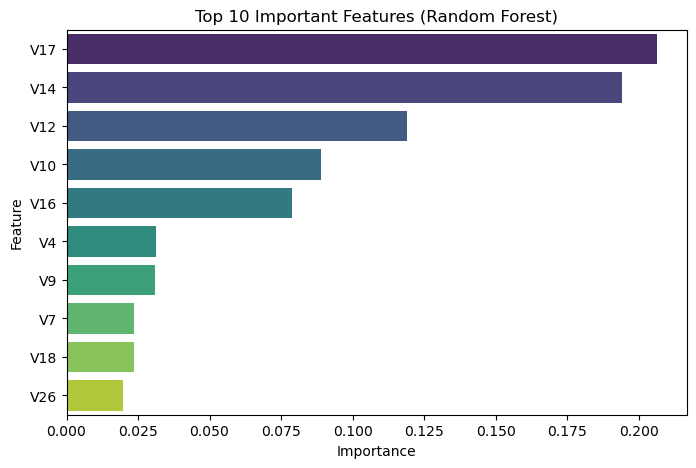

In [45]:
# Get feature importances
importances = best_rf.named_steps['classifier'].feature_importances_
features = X_train.columns
df_importance = pd.DataFrame({'Feature': features, 'Importance': importances}).\
sort_values('Importance', ascending=False)

# Plot top 10 features
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=df_importance.head(10), palette='viridis')
plt.title('Top 10 Important Features (Random Forest)')
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

### Additional Reading
- A detailed explanation of the results, along with the theoretical background required to understand the explanations, is provided in the attached PDF file of the repository.